In [1]:

import logging
from os import listdir
from os.path import splitext
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F

dir_img = Path('/home/igor/ml/solaris_test/tiling/3_3/') # Path('./data/imgs/')
dir_mask = Path('/home/igor/ml/solaris_test/tiling/maskRGB/') # Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

/home/igor/miniconda3/envs/sol/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.data_loading import BasicDataset, BasicDatasetRGB, CarvanaDataset
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet

In [3]:
img_scale = 0.5
val_percent = 0.2
batch_size = 8

In [4]:


dataset = BasicDatasetRGB(dir_img, dir_mask, img_scale)

In [5]:
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))


In [6]:
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [7]:
mask_folder = '/home/igor/ml/solaris_test/tiling/maskRGB/'
mask_path = '/home/igor/ml/solaris_test/tiling/maskRGB/3_3_1.png'

colors = np.array([[0,0,0],[255,0,0],[0,255,0],[0,0,255]])
mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

def mask_to_class(self, mask):

        #target = torch.from_numpy(mask)

        target = mask

        h,w = target.shape[0],target.shape[1]

        masks = torch.empty(h, w, dtype=torch.long)

        #colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()

        #print("colors: ", colors)

        #print("len(colors): " + str(len(colors)))

        target = target.permute(2, 0, 1).contiguous()

        mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

        #print("mapping: " + str(mapping))

        for k in mapping:

            #print("k: " + str(k))

            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))

            validx = (idx.sum(0) == 3) 

            masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
        
        #print(masks)

        return masks

mask=torch.as_tensor( np.asarray(Image.open(mask_path).copy()))
mask1=mask_to_class(None, mask)
print(mask.shape)
print(mask1.shape)




/tmp/ipykernel_463/3700556450.py:43: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  mask=torch.as_tensor( np.asarray(Image.open(mask_path).copy()))


torch.Size([512, 512, 3])
torch.Size([512, 512])


In [8]:
img = Image.fromarray(mask.numpy())

In [9]:
onehot = F.one_hot(mask1, )

onehot.shape

torch.Size([512, 512, 3])

In [10]:
#onehot[400,450]

img_mask = Image.fromarray( 25500 * np.array(onehot[:,:,0].numpy(),dtype=np.uint8))
#img_mask


In [11]:
onehot1 = np.array( onehot.numpy(),dtype=np.uint8)


In [12]:
img2 = Image.fromarray(onehot1.astype(np.uint8) * 255)

In [13]:
torch.as_tensor( onehot1).long().dtype

torch.int64

In [14]:
torch.unique(mask.view(-1,mask.size(2)),dim=0).numpy()

array([[  0,   0,   0],
       [  0, 255,   0]], dtype=uint8)

In [15]:
mask.view(-1,mask.size(2)).shape

torch.Size([262144, 3])

In [16]:
mask.numpy().size

786432

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=4, bilinear=True)
net.load_state_dict(torch.load('/home/igor/ml/Pytorch-UNet/checkpoints/batch8_small.pth', map_location=device))

<All keys matched successfully>

In [21]:
net.to(device=device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [26]:
pred = 0
for batch in val_loader:
    img, true_mask = batch['image'], batch['mask']
    img = img.to(device=device, dtype=torch.float32)
    #pred = 0
    with torch.no_grad():
        print(img.shape)
        mask_pred = net(img)
        mask_pred2 = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
        pred = mask_pred2
    break 


# compute the Dice score, ignoring background
#dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

torch.Size([8, 3, 256, 256])


In [35]:
#input_net = (torch.tensor(np.ones([256,3,3,3])).to(device=device, dtype=torch.float32))
predArray = pred.cpu().numpy()
imArray = img.cpu().numpy()

In [34]:
#imArray.shape == (8, 3, 256, 256)

(8, 3, 256, 256)

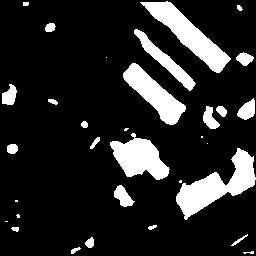

In [42]:
predArray[0,0,:].shape
Image.fromarray(predArray[0,1,:].astype(np.uint8) * 255)

In [65]:
import matplotlib.pyplot as plt

In [54]:
array_real = img.cpu().permute([0,2,3,1]).numpy()[0]

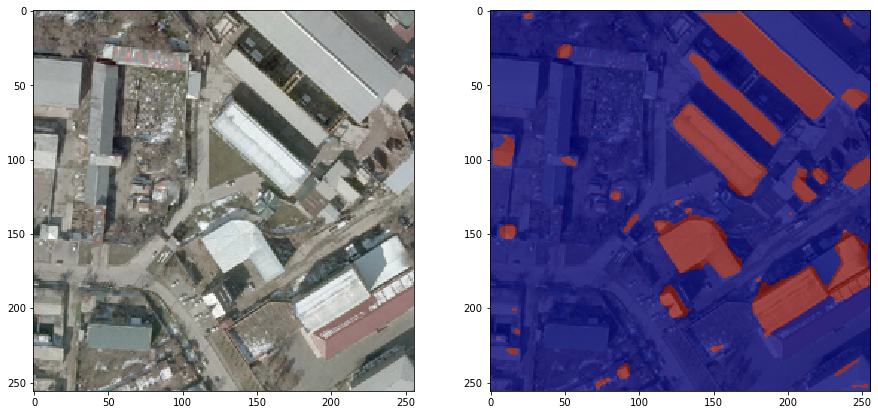

In [73]:
#array_real * 255

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(array_real, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(array_real, 'gray', interpolation='none')
plt.imshow(predArray[0,1,:], 'jet', interpolation='none', alpha=0.7)
plt.show()

1.0